The three open-dataset tasks are independent arrays being reprojected independently. The low-memory way to run this is to run each one independently.

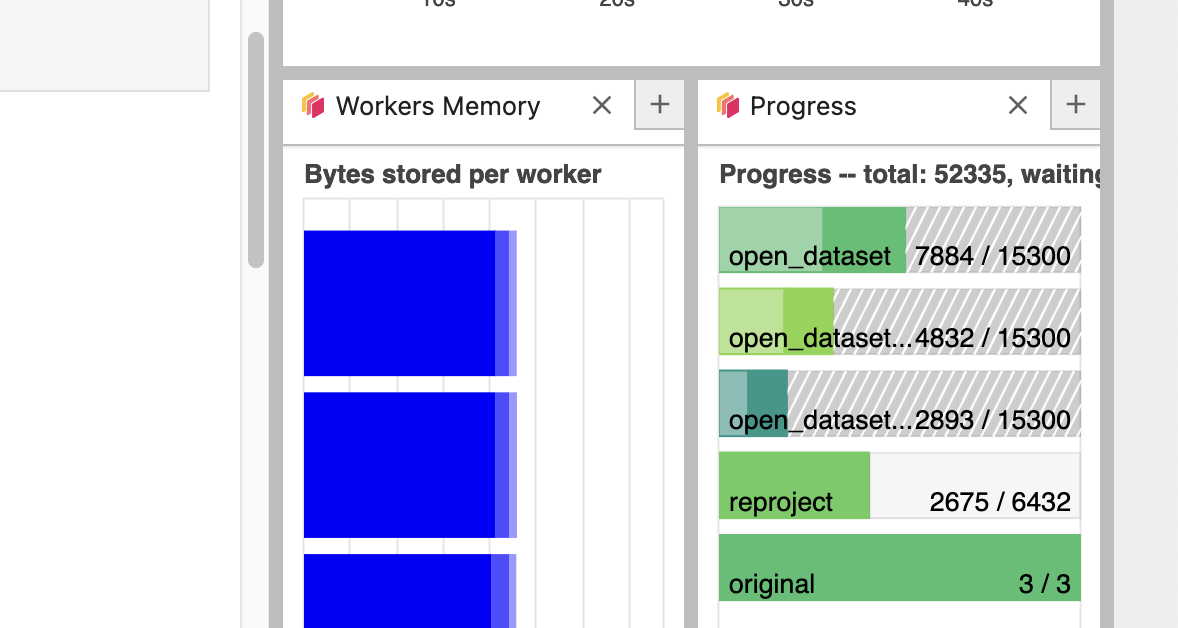

In [5]:
import arraylake as al
import xarray as xr

# To run on coiled, you'll need to set token=TOKEN here,
# and then set that token as coiled.Cluster(environ={"ARRAYLAKE_TOKEN": TOKEN})
alclient = al.Client()
alclient

Client(service_uri='https://api.earthmover.io', auth_org='earthmover')

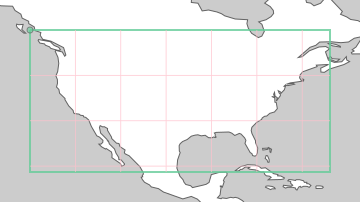

In [4]:
import odc.geo.xr
from odc.geo.geobox import GeoBox

outbox = GeoBox.from_bbox(
    (-130.24, 21.58, -64.12, 52.88),
    crs="epsg:4326", resolution=0.01
)
outbox

## Read data

In [6]:
lf = (
    alclient.get_repo('earthmover-public/landfire')
    .to_xarray(
        group="lf2020", decode_coords="all", chunks={"y": 1024, "x": 1024}
    )
)
lf

<xarray.Dataset> Size: 381GB
Dimensions:       (y: 101538, x: 156335)
Coordinates:
    spatial_ref   int64 8B ...
  * x             (x) float64 1MB -2.362e+06 -2.362e+06 ... 2.328e+06 2.328e+06
  * y             (y) float64 812kB 3.267e+06 3.267e+06 ... 2.213e+05 2.213e+05
Data variables:
    aspect        (y, x) float64 127GB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    elevation     (y, x) float64 127GB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    slope_degree  (y, x) float64 127GB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
Attributes:
    description:  Landfire 2020 topographic data describing the landscape of ...

## Reproject

In [7]:
CHUNKSIZE = (100, 100)
reproj_lf = xr.merge(
    [lf[["slope_degree", "elevation"]].odc.reproject(how=outbox, resampling="average", chunks=CHUNKSIZE),
    lf[["aspect"]].odc.reproject(how=outbox, resampling="mode", chunks=CHUNKSIZE),
    ]
)

for var in reproj_lf:
    reproj_lf[var].encoding["chunks"] = CHUNKSIZE
reproj_lf

<xarray.Dataset> Size: 497MB
Dimensions:       (latitude: 3130, longitude: 6612)
Coordinates:
  * latitude      (latitude) float64 25kB 52.88 52.87 52.85 ... 21.59 21.59
  * longitude     (longitude) float64 53kB -130.2 -130.2 ... -64.14 -64.13
    spatial_ref   int32 4B 4326
Data variables:
    slope_degree  (latitude, longitude) float64 166MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    elevation     (latitude, longitude) float64 166MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    aspect        (latitude, longitude) float64 166MB dask.array<chunksize=(100, 100), meta=np.ndarray>

In [9]:
newrepo = alclient.get_or_create_repo("coiled/landfire")

In [ ]:
reproj_lf.load().to_zarr(newrepo.store, group="landfire/4326")